# Import Dependencies

In [ ]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus =  tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
data_dir = 'drive/MyDrive/Training/Datasets/age_race/UTKFace'
image_exts = ['jpeg', 'jpg', 'png', 'bmp']
image_calss = os.listdir(data_dir)

In [ ]:
data_dir = 'drive/MyDrive/Training/Datasets/age_race/UTKFace'
files = os.listdir(data_dir)
size = len(files)
print("Total samples:",size)

Total samples: 23738


In [ ]:
files = os.listdir(data_dir)
images = []
ages =[]
race = []
from concurrent.futures import ThreadPoolExecutor

def process_image(file):
  try:
    image = cv2.imread(os.path.join(data_dir, file), cv2.IMREAD_GRAYSCALE)
    if image is not None:
      image = cv2.resize(image, dsize=(256, 256))
      image = image.reshape((image.shape[0], image.shape[1], 1))
      images.append(image)
      split_var = file.split('_')
      ages.append(split_var[0])
      race.append(int(split_var[2]) )
    pass
  except Exception as e:
    print(f"Error processing {file}: {str(e)}")

with ThreadPoolExecutor() as executor:
    executor.map(process_image, files)

Error processing 61_1_20170109142408075.jpg.chip.jpg: invalid literal for int() with base 10: '20170109142408075.jpg.chip.jpg'
Error processing 61_1_20170109150557335.jpg.chip.jpg: invalid literal for int() with base 10: '20170109150557335.jpg.chip.jpg'
Error processing 39_1_20170116174525125.jpg.chip.jpg: invalid literal for int() with base 10: '20170116174525125.jpg.chip.jpg'


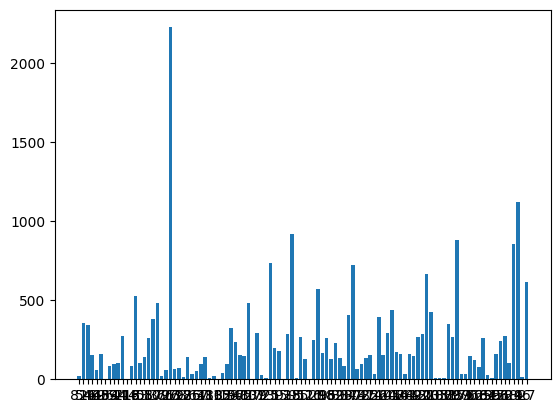

Max value: 99


In [ ]:
import matplotlib.pyplot as plt
x_ages = list(set(ages))
y_ages = [ages.count(i) for i in x_ages]
plt.bar(x_ages,y_ages)
plt.show()
print("Max value:",max(ages))

race: 0 Age: 96


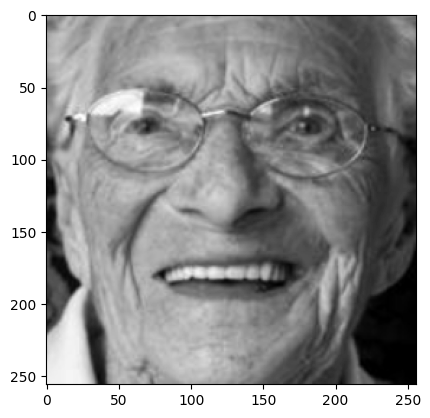

In [ ]:
def display(img):
    plt.imshow(img[:,:,0])
    plt.set_cmap('gray')
    plt.show()
idx = 500
sample = images[idx]
print("race:",race[idx],"Age:",ages[idx])
display(sample)

# Load Data

# Preprocessing

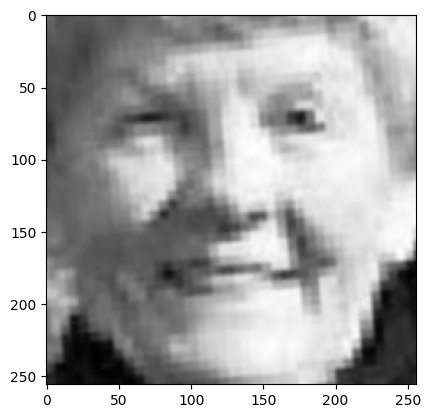

In [ ]:
target = np.zeros((size,2),dtype='float32')
features = np.zeros((size,sample.shape[0],sample.shape[1],1),dtype = 'float32')
for i in range(size-3):
    target[i,0] = ages[i]
    target[i,1] = int(race[i])
    features[i] = images[i]
features = features / 255
display(features[550])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2,shuffle  = True)
print("Samples in Training:",x_train.shape[0])
print("Samples in Testing:",x_test.shape[0])

Samples in Training: 18990
Samples in Testing: 4748


# Predict age

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Create the age_model
age_model = Sequential()

# Convolutional layers
age_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 1)))
age_model.add(MaxPooling2D((2, 2)))
age_model.add(Conv2D(64, (3, 3), activation='relu'))
age_model.add(MaxPooling2D((2, 2)))
age_model.add(Conv2D(128, (3, 3), activation='relu'))
age_model.add(MaxPooling2D((2, 2)))

# Fully connected layers
age_model.add(Flatten())
age_model.add(Dense(128, activation='relu'))
age_model.add(Dense(64, activation='relu'))
age_model.add(Dense(1, activation='linear'))  # Output layer for regression

# Compile the model
age_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


In [ ]:
history_age = age_model.fit(x_train, y_train[:,0], validation_data=(x_test,y_test[:,0]), epochs = 25)

Epoch 1/25
594/594 [==============================] - 44s 65ms/step - loss: 301.5259 - mae: 12.9959 - val_loss: 198.1381 - val_mae: 11.1100
Epoch 2/25
594/594 [==============================] - 35s 59ms/step - loss: 154.3916 - mae: 9.0965 - val_loss: 125.0264 - val_mae: 8.0801
Epoch 3/25
594/594 [==============================] - 35s 58ms/step - loss: 110.6790 - mae: 7.6044 - val_loss: 121.0933 - val_mae: 7.6991
Epoch 4/25
594/594 [==============================] - 35s 58ms/step - loss: 91.6101 - mae: 6.9392 - val_loss: 98.8522 - val_mae: 7.1437
Epoch 5/25
594/594 [==============================] - 35s 58ms/step - loss: 77.4933 - mae: 6.4443 - val_loss: 98.9100 - val_mae: 7.0089
Epoch 6/25
594/594 [==============================] - 35s 58ms/step - loss: 66.3879 - mae: 5.9462 - val_loss: 99.5394 - val_mae: 6.9822
Epoch 7/25
594/594 [==============================] - 35s 58ms/step - loss: 57.1227 - mae: 5.5486 - val_loss: 98.7486 - val_mae: 7.1203
Epoch 8/25
594/594 [====================

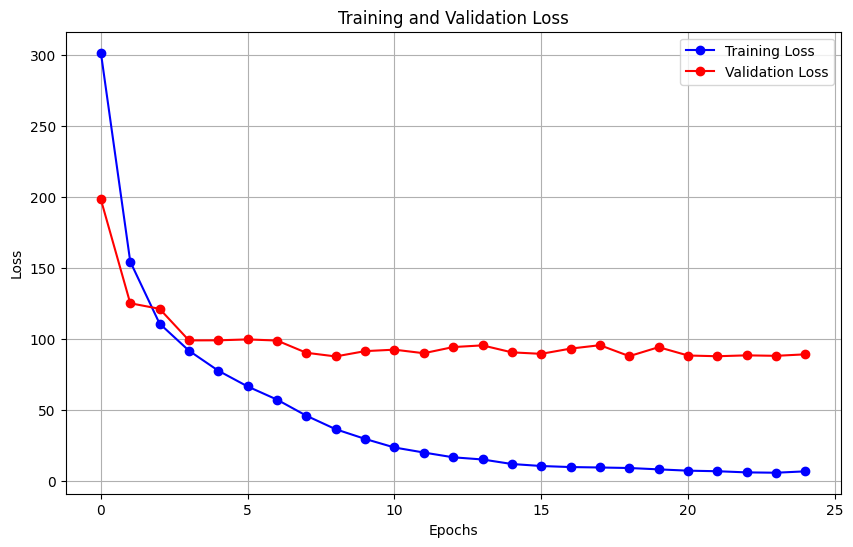

In [ ]:
import matplotlib.pyplot as plt

# Access the training and validation loss from the history
train_loss = history_age.history['loss']
val_loss = history_age.history['val_loss']

# Create a plot for training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss', color='blue', marker='o')
plt.plot(val_loss, label='Validation Loss', color='red', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Save the model

In [ ]:
from tensorflow.keras.models import load_model
age_model.save(os.path.join('drive/MyDrive/Training/Save_models', 'age_6_pred.h5'))